# Data Science, Classification Analysis 

## Data Cleaning, Feature Engineering, Imputation, and Classification.

This Notepad has been designed to be run on top of the Jupyter Tensorflow Docker instance found in the link below: 
- https://github.com/jupyter/docker-stacks/tree/master/tensorflow-notebook

## Checking Number of CPU's available to Docker container

Ideally, and for this Notebook to run in a reasonable time, your Docker container should have 4 cores or more available.

In [1]:
!cat /proc/cpuinfo | awk '/^processor/{print $3}' | tail -1

6


## Import Standard Python Libraries

In [2]:
import io, os, sys, types, time, datetime, math, random, requests, subprocess, StringIO

## Packages Install

We'll now install a few more libraries. This is an easy way to install libraries in a way that are recognised and managed by conda. Do this once and then comment it out for subsequent runs.

In [3]:
!conda install --yes -c conda-forge missingno
!conda install --yes -c anaconda requests

Fetching package metadata ...........
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/python2:

The following packages will be UPDATED:

    numexpr: 2.6.2-np113py27_0 conda-forge --> 2.6.2-np113py27_nomkl_0 defaults [nomkl]

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/python2:

The following packages will be SUPERSEDED by a higher-priority channel:

    requests: 2.18.3-py27_0 conda-forge --> 2.14.2-py27_0 anaconda



## Packages Update

There's a lot of packages available to us, and most of them were installed when running the dockerfile that created the docker instance. Let's make sure they are all up to date. Do this once and then comment it out for subsequent runs.

In [4]:
!conda update --yes --all

Fetching package metadata ...........
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/python2:

The following packages will be UPDATED:

    requests: 2.14.2-py27_0           anaconda --> 2.18.3-py27_0     conda-forge

The following packages will be SUPERSEDED by a higher-priority channel:

    numexpr:  2.6.2-np113py27_nomkl_0 defaults [nomkl] --> 2.6.2-np113py27_0 conda-forge



## Packages Import

These are all the packages we'll be using. Importing individual libraries make it easy for us to use them without having to call the parent libraries.

In [5]:
# Data Manipulation 
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D

# Feature Selection and Encoding
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning 
import sklearn.ensemble as ske
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Grid and Random Search
import scipy.stats as st
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Metrics
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plot the Figures Inline
%matplotlib inline

## Listing Installed Packages

We could list all installed packages to check whether a package has already been installed.

In [6]:
conda_packages_list = StringIO.StringIO(subprocess.Popen(["conda", "list"], 
                                                         stdout=subprocess.PIPE).communicate()[0])
conda_packages_list = pd.read_csv(conda_packages_list, 
                                  names=['Package Name','Version','Python Version','Repo','Other'], 
                                  delim_whitespace=True, engine='python', skiprows=3)
conda_packages_list.head(5)

,Package Name,Version,Python Version,Repo,Other
0,backports.shutil_get_terminal_size,1.0.0,py27_1,conda-forge,None
1,backports.weakref,1.0rc1,py27_0,conda-forge,None
2,backports_abc,0.5,py27_0,conda-forge,None
3,beautifulsoup4,4.5.3,py27_0,conda-forge,None
4,bkcharts,0.2,py27_0,conda-forge,None


## Objective

In this Jupyter Notepad, we will using the Census Income Dataset to predict whether an individual's income exceeds $50K/yr based on census data.

The dataset can be found here: https://archive.ics.uci.edu/ml/datasets/adult

## Data Download and Loading

Let's download the data and save it to a folder in our local directory called 'dataset'. Download it once, and then comment the code out for subsequent runs.

After downloading the data, we load it directly from Disk into a Pandas Dataframe in Memory. Depending on the memory available to the Docker instance, this may be a problem.

The data comes separated into the Training and Test datasets. We will join the two for data exploration, and then separate them again before running our algorithms.

In [7]:
# Download
DATASET = (
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names",
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
)

def download_data(path='dataset', urls=DATASET):
    if not os.path.exists(path):
        os.mkdir(path)

    for url in urls:
        response = requests.get(url)
        name = os.path.basename(url)
        with open(os.path.join(path, name), 'w') as f:
            f.write(response.content)

download_data()

In [8]:
# Load Training and Test Data Sets
headers = ['age', 'workclass', 'fnlwgt', 
           'education', 'education-num', 
           'marital-status', 'occupation', 
           'relationship', 'race', 'sex', 
           'capital-gain', 'capital-loss', 
           'hours-per-week', 'native-country', 
           'predclass']
training_raw = pd.read_csv('dataset/adult.data', 
                       header=None, 
                       names=headers, 
                       sep=',\s', 
                       na_values=["?"], 
                       engine='python')
test_raw = pd.read_csv('dataset/adult.test', 
                      header=None, 
                      names=headers, 
                      sep=',\s', 
                      na_values=["?"], 
                      engine='python', 
                      skiprows=1)

In [9]:
# Join Datasets
dataset_raw = training_raw.append(test_raw)
dataset_raw.reset_index(inplace=True)
dataset_raw.drop('index',inplace=True,axis=1)

In [10]:
# Displaying the size of the Dataframe in Memory
def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("Bytes", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "%s %s" % (s, size_name[i])
convert_size(dataset_raw.memory_usage().sum())

'5.59 MB'

## Data Exploration - Univariate

When exploring our dataset and its features, we have many options available to us. We can explore each feature individually, or compare pairs of features, finding the correlation between. Let's start with some simple Univariate (one feature) analysis.

Features can be of multiple types:
- **Nominal:**  is for mutual exclusive, but not ordered, categories.
- **Ordinal:** is one where the order matters but not the difference between values.
- **Interval:** is a measurement where the difference between two values is meaningful.
- **Ratio:** has all the properties of an interval variable, and also has a clear definition of 0.0.

There are multiple ways of manipulating each feature type, but for simplicity, we'll define only two feature types:
- **Numerical:** any feature that contains numeric values.
- **Categorical:** any feature that contains categories, or text.

In [11]:
# Describing all the Numerical Features
dataset_raw.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [12]:
# Describing all the Categorical Features
dataset_raw.describe(include=['O'])

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,predclass
count,46043,48842,48842,46033,48842,48842,48842,47985,48842
unique,8,16,7,14,6,5,2,41,4
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,33906,15784,22379,6172,19716,41762,32650,43832,24720


In [13]:
# Let's have a quick look at our data
dataset_raw.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,predclass
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


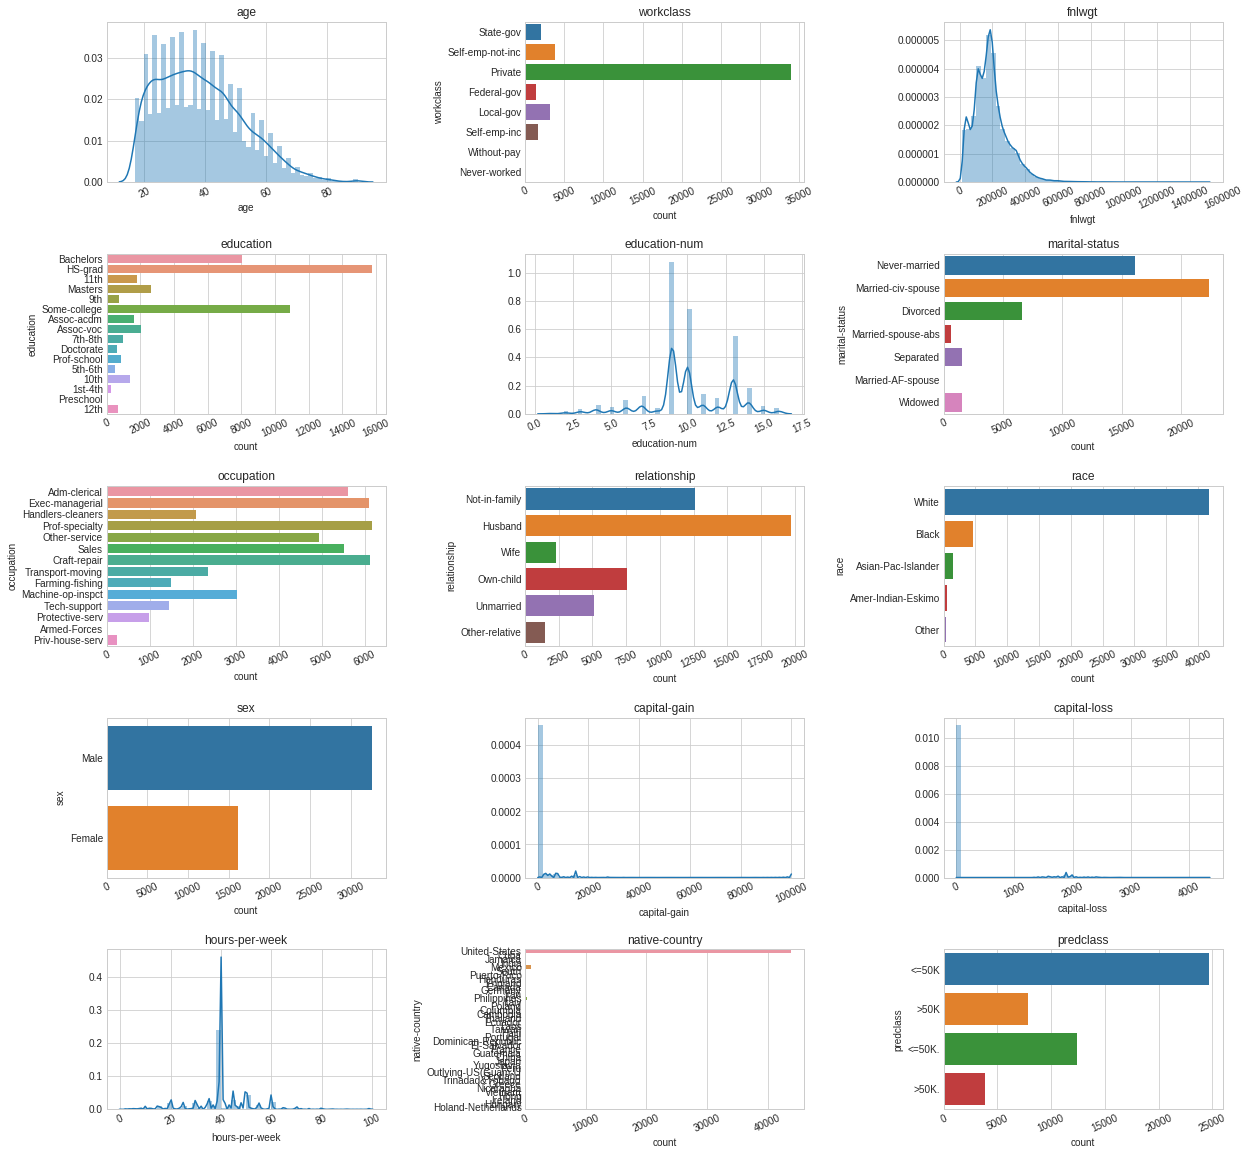

In [14]:
# Let’s plot the distribution of each feature
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)
    
plot_distribution(dataset_raw, cols=3, width=20, height=20, hspace=0.45, wspace=0.5)

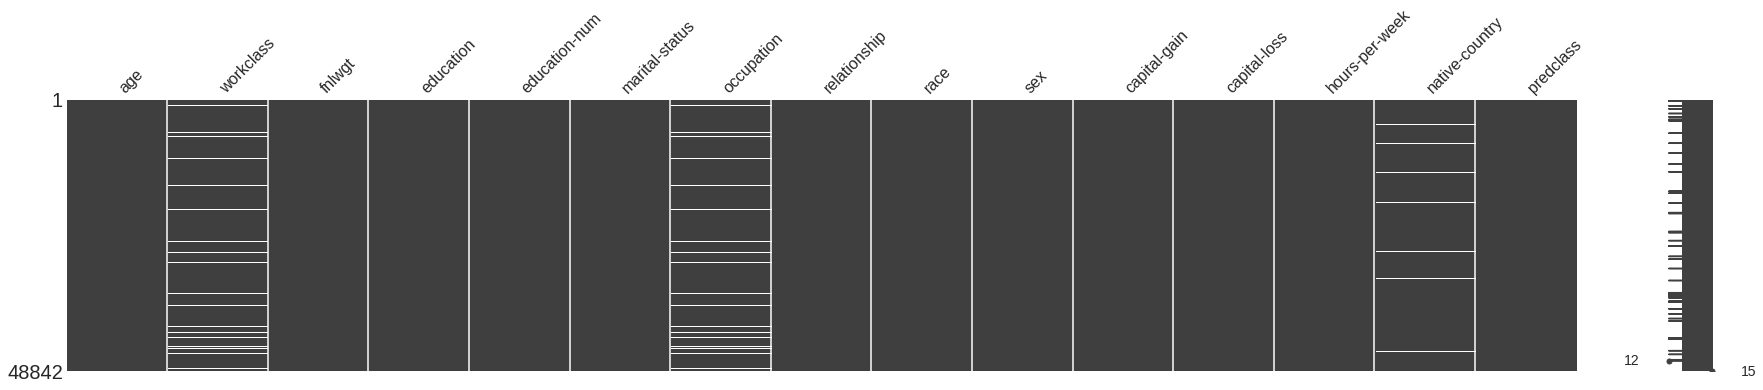

In [15]:
# How many missing values are there in our dataset?
missingno.matrix(dataset_raw, figsize = (30,5))

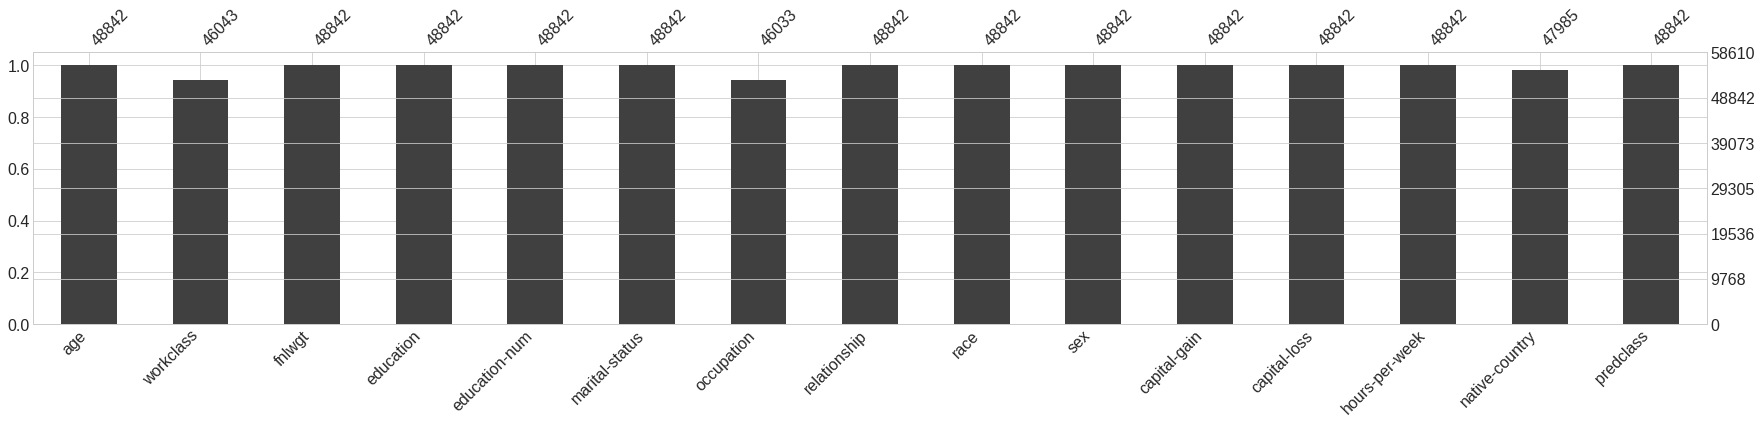

In [16]:
missingno.bar(dataset_raw, sort='ascending', figsize = (30,5))

# Feature Cleaning, Engineering, and Imputation

**Cleaning:**
To clean our data, we'll need to work with:

- **Missing values:** Either omit elements from a dataset that contain missing values or impute them (fill them in).
- **Special values:** Numeric variables are endowed with several formalized special values including ±Inf, NA and NaN. Calculations involving special values often result in special values, and need to be handled/cleaned.
- **Outliers:** They should be detected, but not necessarily removed. Their inclusion in the analysis is a statistical decision.
- **Obvious inconsistencies:** A person's age cannot be negative, a man cannot be pregnant and an under-aged person cannot possess a drivers license. Find the inconsistencies and plan for them.

**Engineering:**
There are multiple techniques for feature engineering:
- **Decompose:** Converting 2014-09-20T20:45:40Z into categorical attributes like hour_of_the_day, part_of_day, etc.
- **Discretization:** We can choose to either discretize some of the continuous variables we have, as some algorithms will perform faster. We are going to do both, and compare the results of the ML algorithms on both discretized and non discretised datasets. We'll call these datasets:

- dataset_bin => where Continuous variables are Discretised
- dataset_con => where Continuous variables are Continuous 

- **Reframe Numerical Quantities:** Changing from grams to kg, and losing detail might be both wanted and efficient for calculation
- **Feature Crossing:** Creating new features as a combination of existing features. Could be multiplying numerical features, or combining categorical variables. This is a great way to add domain expertise knowledge to the dataset.
    
**Imputation:**
We can impute missing values in a number of different ways:
- **Hot-Deck:**	The technique then finds the first missing value and uses the cell value immediately prior to the data that are missing to impute the missing value.
- **Cold-Deck:** Selects donors from another dataset to complete missing data.
- **Mean-substitution:** Another imputation technique involves replacing any missing value with the mean of that variable for all other cases, which has the benefit of not changing the sample mean for that variable.
- **Regression:** A regression model is estimated to predict observed values of a variable based on other variables, and that model is then used to impute values in cases where that variable is missing.

In [17]:
# To perform our data analysis, let's create new dataframes.
dataset_bin = pd.DataFrame() # To contain our dataframe with our discretised continuous variables 
dataset_con = pd.DataFrame() # To contain our dataframe with our continuous variables 

### Feature: Class

In [18]:
# Let's fix the Class Feature
dataset_raw.loc[dataset_raw['predclass'] == '>50K', 'predclass'] = 1
dataset_raw.loc[dataset_raw['predclass'] == '>50K.', 'predclass'] = 1
dataset_raw.loc[dataset_raw['predclass'] == '<=50K', 'predclass'] = 0
dataset_raw.loc[dataset_raw['predclass'] == '<=50K.', 'predclass'] = 0

dataset_bin['predclass'] = dataset_raw['predclass']
dataset_con['predclass'] = dataset_raw['predclass']

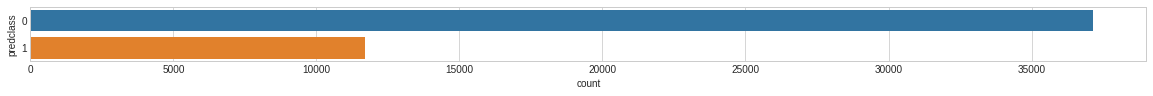

In [19]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,1)) 
sns.countplot(y="predclass", data=dataset_bin);

### Feature: Age

For our first feature: "age", we use the Pandas Cut function to bin the data in equally sized buckets. We will also add our original feature to the dataset_con dataframe.

In [20]:
dataset_bin['age'] = pd.cut(dataset_raw['age'], 10) # discretised 
dataset_con['age'] = dataset_raw['age'] # non-discretised

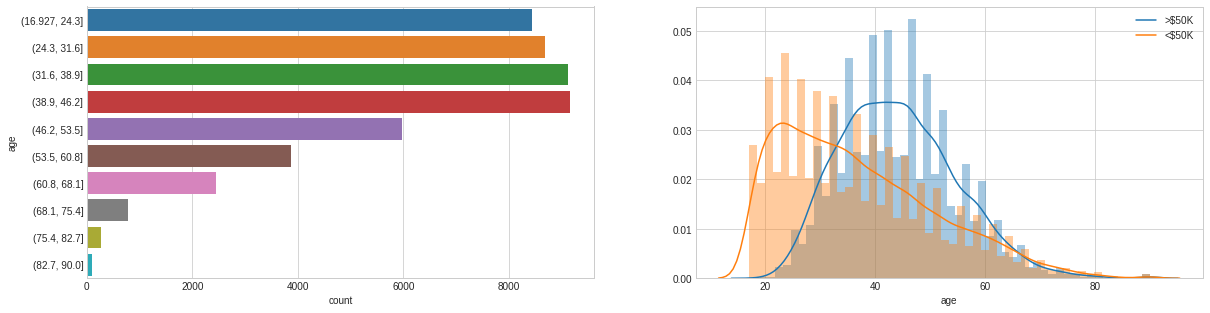

In [21]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,5)) 
plt.subplot(1, 2, 1)
sns.countplot(y="age", data=dataset_bin);
plt.subplot(1, 2, 2)
sns.distplot(dataset_con.loc[dataset_con['predclass'] == 1]['age'], kde_kws={"label": ">$50K"});
sns.distplot(dataset_con.loc[dataset_con['predclass'] == 0]['age'], kde_kws={"label": "<$50K"});

### Feature: Workclass

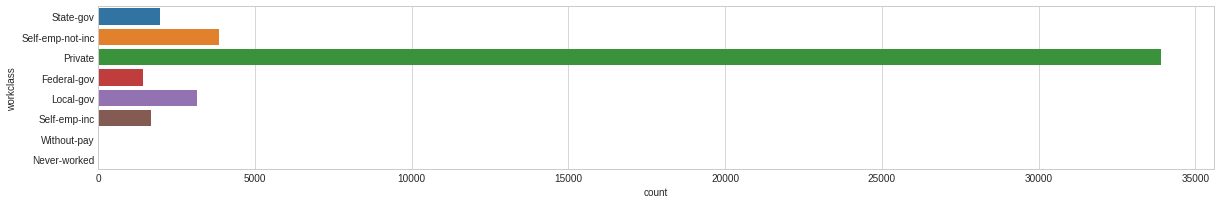

In [22]:
# Can we bucket some of these groups?
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,3)) 
sns.countplot(y="workclass", data=dataset_raw);

In [23]:
# There are too many groups here, we can group someof them together.
# Create buckets for Workclass
dataset_raw.loc[dataset_raw['workclass'] == 'Without-pay', 'workclass'] = 'Not Working'
dataset_raw.loc[dataset_raw['workclass'] == 'Never-worked', 'workclass'] = 'Not Working'
dataset_raw.loc[dataset_raw['workclass'] == 'Federal-gov', 'workclass'] = 'Fed-gov'
dataset_raw.loc[dataset_raw['workclass'] == 'State-gov', 'workclass'] = 'Non-fed-gov'
dataset_raw.loc[dataset_raw['workclass'] == 'Local-gov', 'workclass'] = 'Non-fed-gov'
dataset_raw.loc[dataset_raw['workclass'] == 'Self-emp-not-inc', 'workclass'] = 'Self-emp'
dataset_raw.loc[dataset_raw['workclass'] == 'Self-emp-inc', 'workclass'] = 'Self-emp'

dataset_bin['workclass'] = dataset_raw['workclass']
dataset_con['workclass'] = dataset_raw['workclass']

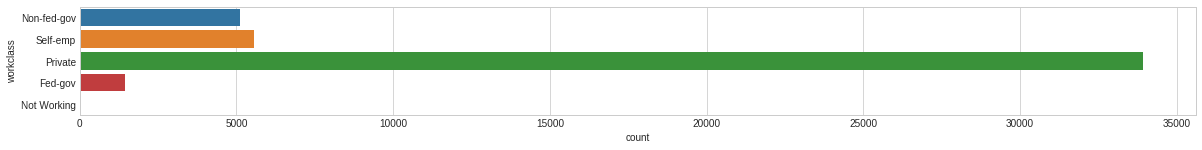

In [24]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,2)) 
sns.countplot(y="workclass", data=dataset_bin);

### Feature: Occupation

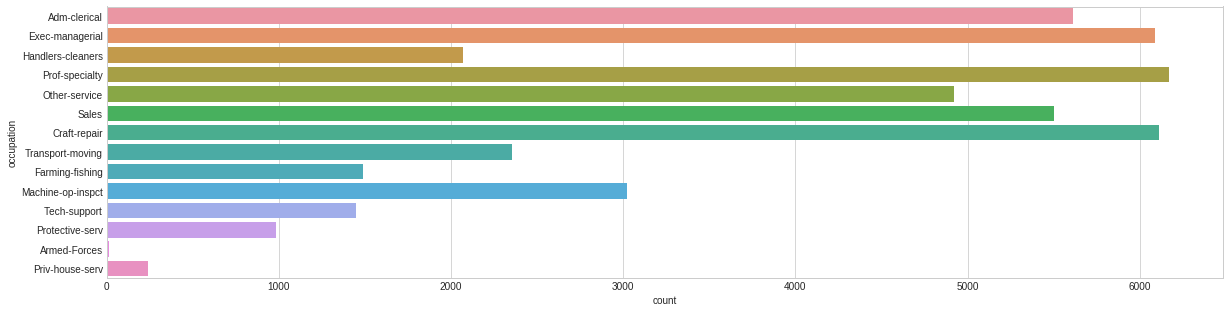

In [25]:
# Can we bucket some of these groups?
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,5)) 
sns.countplot(y="occupation", data=dataset_raw);

In [26]:
# Create buckets for Occupation
dataset_raw.loc[dataset_raw['occupation'] == 'Adm-clerical', 'occupation'] = 'Admin'
dataset_raw.loc[dataset_raw['occupation'] == 'Armed-Forces', 'occupation'] = 'Military'
dataset_raw.loc[dataset_raw['occupation'] == 'Craft-repair', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Exec-managerial', 'occupation'] = 'Office Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Farming-fishing', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Handlers-cleaners', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Machine-op-inspct', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Other-service', 'occupation'] = 'Service'
dataset_raw.loc[dataset_raw['occupation'] == 'Priv-house-serv', 'occupation'] = 'Service'
dataset_raw.loc[dataset_raw['occupation'] == 'Prof-specialty', 'occupation'] = 'Professional'
dataset_raw.loc[dataset_raw['occupation'] == 'Protective-serv', 'occupation'] = 'Military'
dataset_raw.loc[dataset_raw['occupation'] == 'Sales', 'occupation'] = 'Office Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Tech-support', 'occupation'] = 'Office Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Transport-moving', 'occupation'] = 'Manual Labour'

dataset_bin['occupation'] = dataset_raw['occupation']
dataset_con['occupation'] = dataset_raw['occupation']

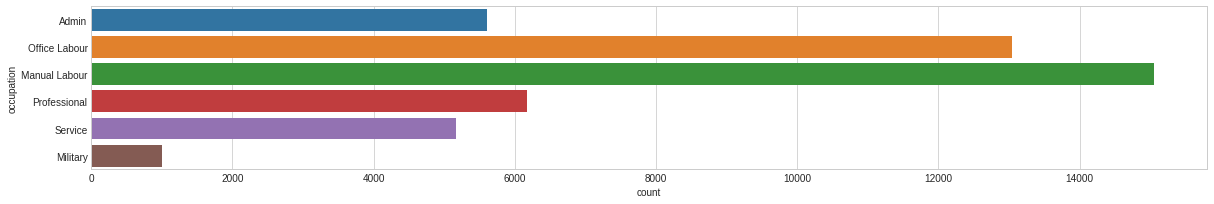

In [27]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,3))
sns.countplot(y="occupation", data=dataset_bin);

### Feature: Native Country

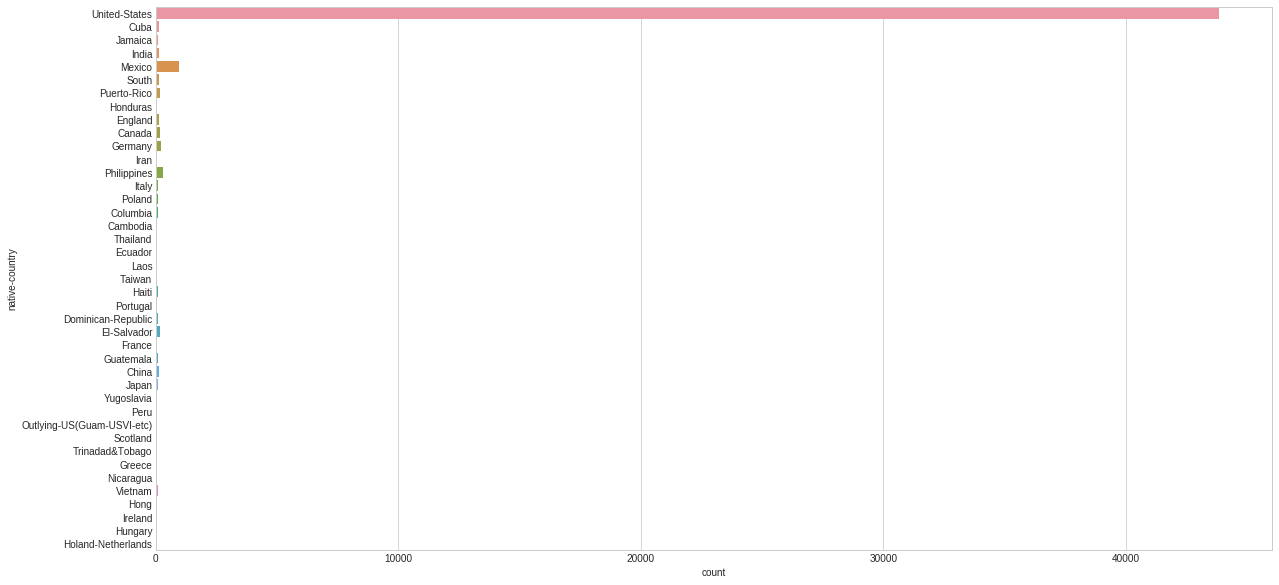

In [28]:
# Can we bucket some of these groups?
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,10)) 
sns.countplot(y="native-country", data=dataset_raw);

In [29]:
dataset_raw.loc[dataset_raw['native-country'] == 'Cambodia'                    , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Canada'                      , 'native-country'] = 'British-Commonwealth'    
dataset_raw.loc[dataset_raw['native-country'] == 'China'                       , 'native-country'] = 'China'       
dataset_raw.loc[dataset_raw['native-country'] == 'Columbia'                    , 'native-country'] = 'South-America'    
dataset_raw.loc[dataset_raw['native-country'] == 'Cuba'                        , 'native-country'] = 'South-America'        
dataset_raw.loc[dataset_raw['native-country'] == 'Dominican-Republic'          , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Ecuador'                     , 'native-country'] = 'South-America'     
dataset_raw.loc[dataset_raw['native-country'] == 'El-Salvador'                 , 'native-country'] = 'South-America' 
dataset_raw.loc[dataset_raw['native-country'] == 'England'                     , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == 'France'                      , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == 'Germany'                     , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == 'Greece'                      , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Guatemala'                   , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Haiti'                       , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Holand-Netherlands'          , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == 'Honduras'                    , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Hong'                        , 'native-country'] = 'China'
dataset_raw.loc[dataset_raw['native-country'] == 'Hungary'                     , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'India'                       , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == 'Iran'                        , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Ireland'                     , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == 'Italy'                       , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == 'Jamaica'                     , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Japan'                       , 'native-country'] = 'APAC'
dataset_raw.loc[dataset_raw['native-country'] == 'Laos'                        , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Mexico'                      , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Nicaragua'                   , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Outlying-US(Guam-USVI-etc)'  , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Peru'                        , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Philippines'                 , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Poland'                      , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Portugal'                    , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Puerto-Rico'                 , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Scotland'                    , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == 'South'                       , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Taiwan'                      , 'native-country'] = 'China'
dataset_raw.loc[dataset_raw['native-country'] == 'Thailand'                    , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Trinadad&Tobago'             , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'United-States'               , 'native-country'] = 'United-States'
dataset_raw.loc[dataset_raw['native-country'] == 'Vietnam'                     , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Yugoslavia'                  , 'native-country'] = 'Euro_Group_2'

dataset_bin['native-country'] = dataset_raw['native-country']
dataset_con['native-country'] = dataset_raw['native-country']

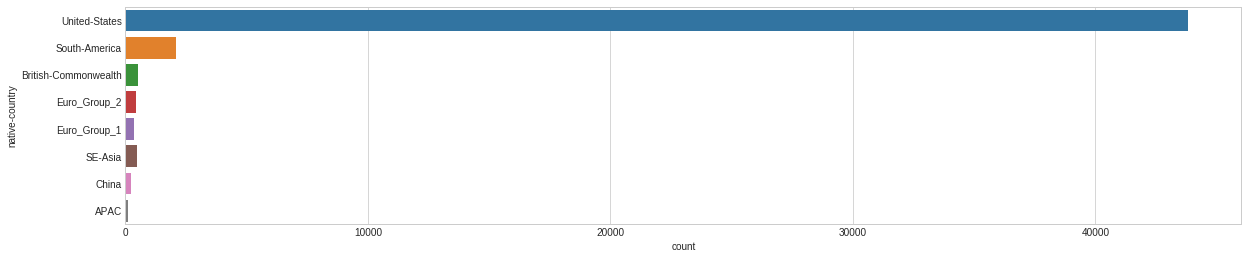

In [30]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,4)) 
sns.countplot(y="native-country", data=dataset_bin);

### Feature: Education

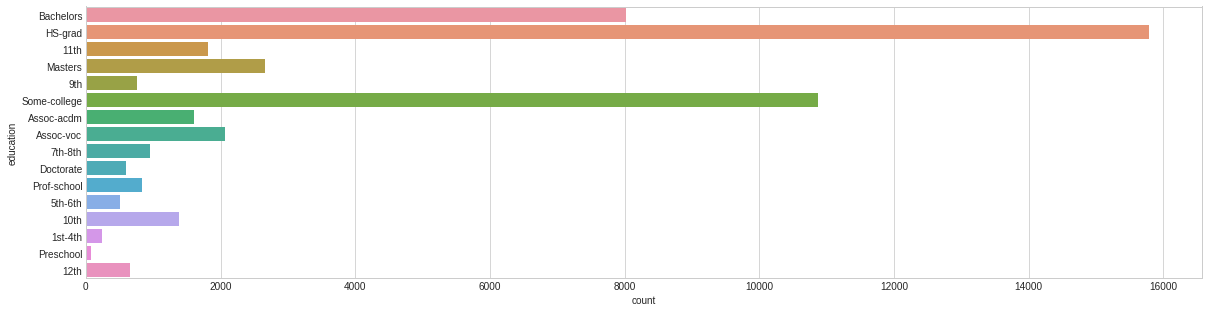

In [31]:
# Can we bucket some of these groups?
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,5)) 
sns.countplot(y="education", data=dataset_raw);

In [32]:
dataset_raw.loc[dataset_raw['education'] == '10th'          , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '11th'          , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '12th'          , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '1st-4th'       , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '5th-6th'       , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '7th-8th'       , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '9th'           , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == 'Assoc-acdm'    , 'education'] = 'Associate'
dataset_raw.loc[dataset_raw['education'] == 'Assoc-voc'     , 'education'] = 'Associate'
dataset_raw.loc[dataset_raw['education'] == 'Bachelors'     , 'education'] = 'Bachelors'
dataset_raw.loc[dataset_raw['education'] == 'Doctorate'     , 'education'] = 'Doctorate'
dataset_raw.loc[dataset_raw['education'] == 'HS-Grad'       , 'education'] = 'HS-Graduate'
dataset_raw.loc[dataset_raw['education'] == 'Masters'       , 'education'] = 'Masters'
dataset_raw.loc[dataset_raw['education'] == 'Preschool'     , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == 'Prof-school'   , 'education'] = 'Professor'
dataset_raw.loc[dataset_raw['education'] == 'Some-college'  , 'education'] = 'HS-Graduate'

dataset_bin['education'] = dataset_raw['education']
dataset_con['education'] = dataset_raw['education']

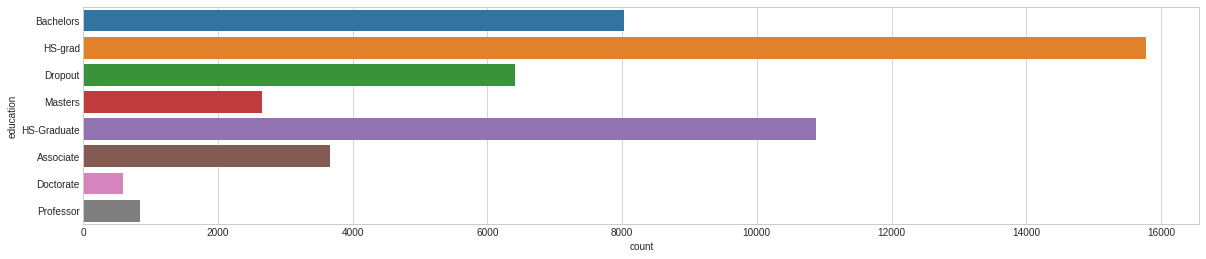

In [33]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,4)) 
sns.countplot(y="education", data=dataset_bin);

### Feature: Marital Status

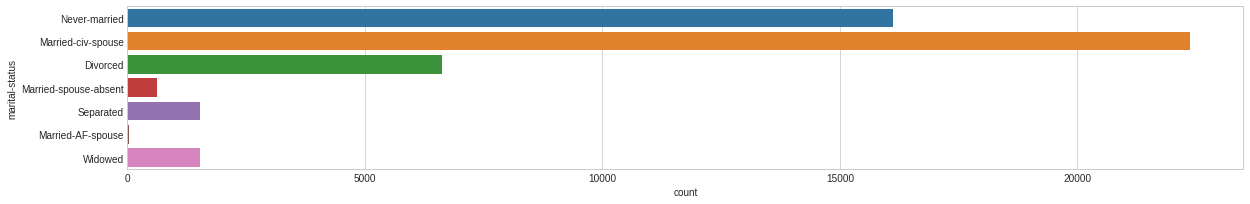

In [34]:
# Can we bucket some of these groups?
plt.figure(figsize=(20,3)) 
sns.countplot(y="marital-status", data=dataset_raw);

In [35]:
dataset_raw.loc[dataset_raw['marital-status'] == 'Never-married'        , 'marital-status'] = 'Never-Married'
dataset_raw.loc[dataset_raw['marital-status'] == 'Married-AF-spouse'    , 'marital-status'] = 'Married'
dataset_raw.loc[dataset_raw['marital-status'] == 'Married-civ-spouse'   , 'marital-status'] = 'Married'
dataset_raw.loc[dataset_raw['marital-status'] == 'Married-spouse-absent', 'marital-status'] = 'Not-Married'
dataset_raw.loc[dataset_raw['marital-status'] == 'Separated'            , 'marital-status'] = 'Separated'
dataset_raw.loc[dataset_raw['marital-status'] == 'Divorced'             , 'marital-status'] = 'Separated'
dataset_raw.loc[dataset_raw['marital-status'] == 'Widowed'              , 'marital-status'] = 'Widowed'

dataset_bin['marital-status'] = dataset_raw['marital-status']
dataset_con['marital-status'] = dataset_raw['marital-status']

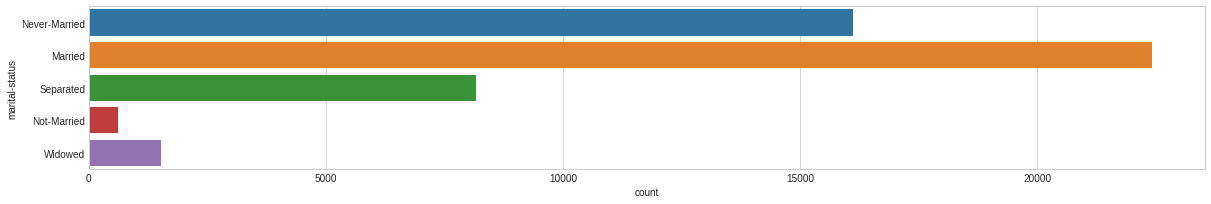

In [36]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,3)) 
sns.countplot(y="marital-status", data=dataset_bin);

### Feature: Final Weight

In [37]:
# Let's use the Pandas Cut function to bin the data in equally sized buckets
dataset_bin['fnlwgt'] = pd.cut(dataset_raw['fnlwgt'], 10)
dataset_con['fnlwgt'] = dataset_raw['fnlwgt']

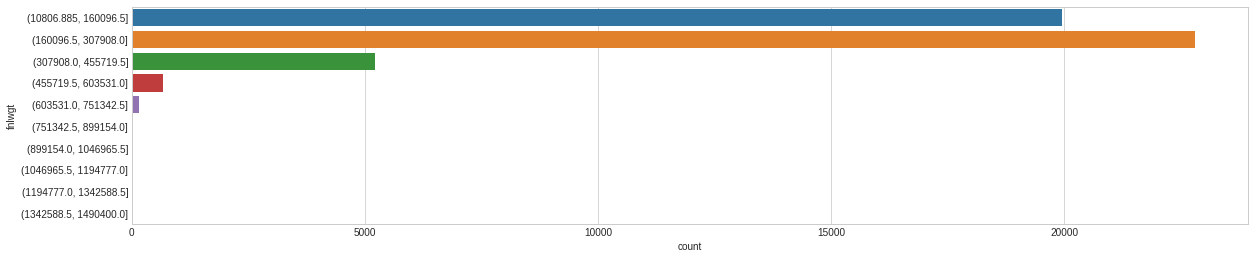

In [38]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,4)) 
sns.countplot(y="fnlwgt", data=dataset_bin);

### Feature: Education Number

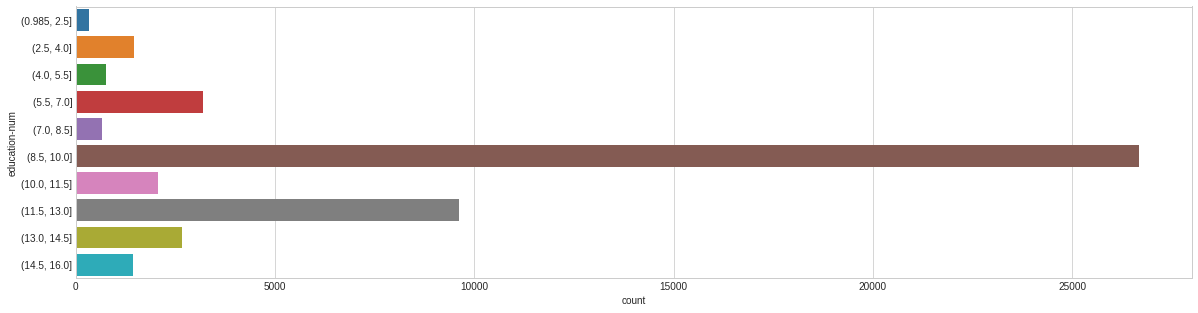

In [39]:
# Let's use the Pandas Cut function to bin the data in equally sized buckets
dataset_bin['education-num'] = pd.cut(dataset_raw['education-num'], 10)
dataset_con['education-num'] = dataset_raw['education-num']

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,5)) 
sns.countplot(y="education-num", data=dataset_bin);

### Feature: Hours per Week

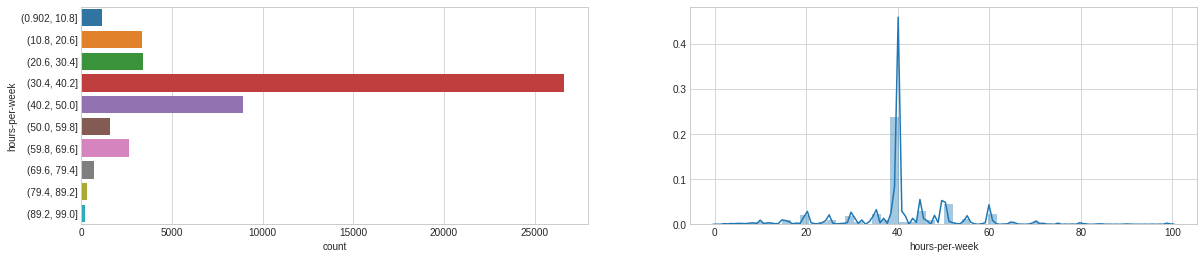

In [40]:
# Let's use the Pandas Cut function to bin the data in equally sized buckets
dataset_bin['hours-per-week'] = pd.cut(dataset_raw['hours-per-week'], 10)
dataset_con['hours-per-week'] = dataset_raw['hours-per-week']

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,4)) 
plt.subplot(1, 2, 1)
sns.countplot(y="hours-per-week", data=dataset_bin);
plt.subplot(1, 2, 2)
sns.distplot(dataset_con['hours-per-week']);

### Feature: Capital Gain

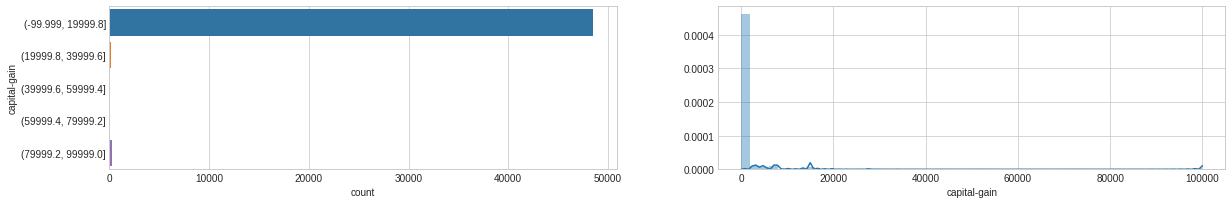

In [41]:
# Let's use the Pandas Cut function to bin the data in equally sized buckets
dataset_bin['capital-gain'] = pd.cut(dataset_raw['capital-gain'], 5)
dataset_con['capital-gain'] = dataset_raw['capital-gain']

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,3)) 
plt.subplot(1, 2, 1)
sns.countplot(y="capital-gain", data=dataset_bin);
plt.subplot(1, 2, 2)
sns.distplot(dataset_con['capital-gain']);

### Feature: Capital Loss

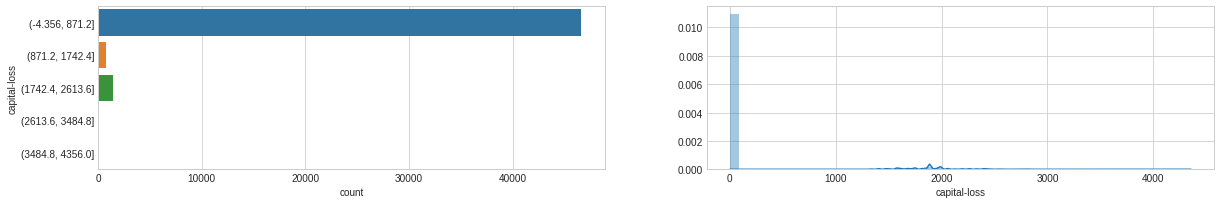

In [42]:
# Let's use the Pandas Cut function to bin the data in equally sized buckets
dataset_bin['capital-loss'] = pd.cut(dataset_raw['capital-loss'], 5)
dataset_con['capital-loss'] = dataset_raw['capital-loss']

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,3)) 
plt.subplot(1, 2, 1)
sns.countplot(y="capital-loss", data=dataset_bin);
plt.subplot(1, 2, 2)
sns.distplot(dataset_con['capital-loss']);

### Features: Race, Sex, Relationship

In [43]:
# Some features we'll consider to be in good enough shape as to pass through
dataset_con['sex'] = dataset_bin['sex'] = dataset_raw['sex']
dataset_con['race'] = dataset_bin['race'] = dataset_raw['race']
dataset_con['relationship'] = dataset_bin['relationship'] = dataset_raw['relationship']

## Bi-variate Analysis

So far, we have analised all features individually. Let's now start combining some of these features together to obtain further insight into the interactions between them.

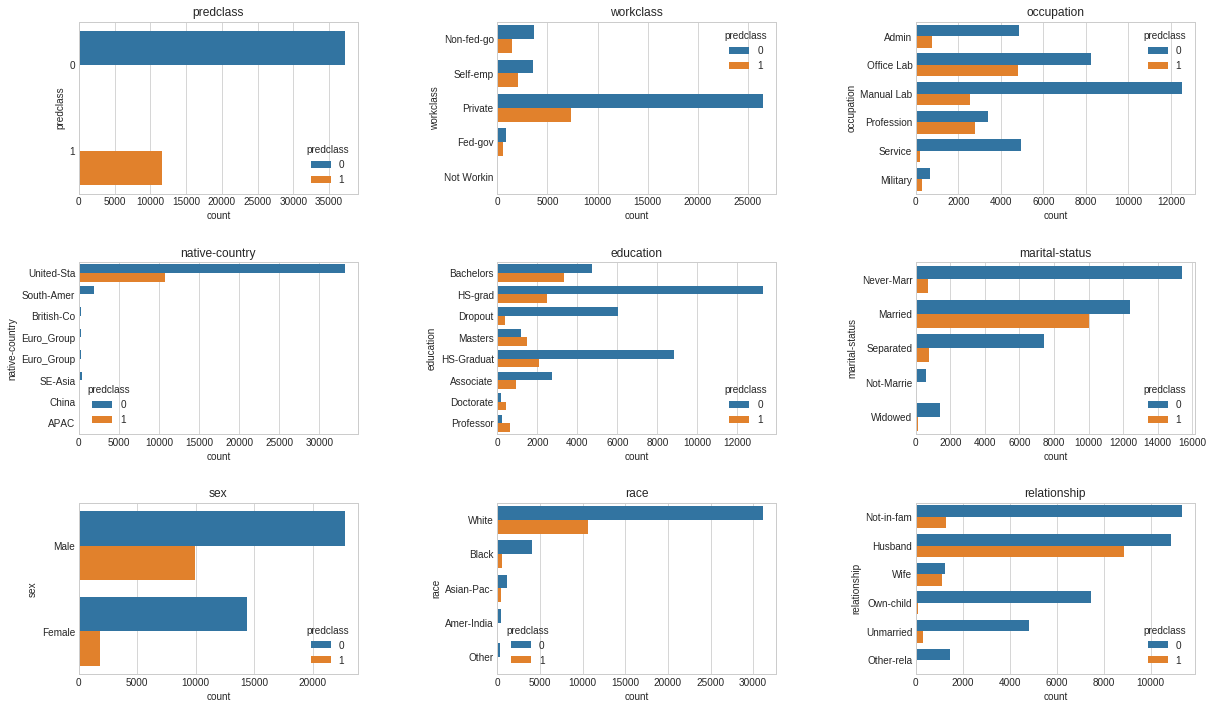

In [44]:
# Plot a count of the categories from each categorical feature split by our prediction class: salary - predclass.
def plot_bivariate_bar(dataset, hue, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    dataset = dataset.select_dtypes(include=[np.object])
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, hue=hue, data=dataset)
            substrings = [s.get_text()[:10] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            
plot_bivariate_bar(dataset_con, hue='predclass', cols=3, width=20, height=12, hspace=0.4, wspace=0.5)

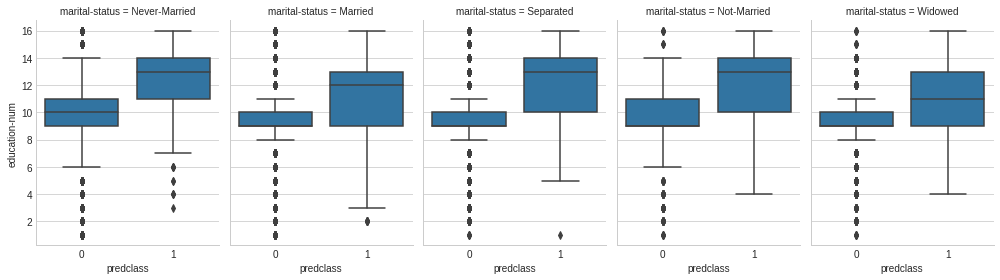

In [45]:
# Effect of Marital Status and Education on Income, across Marital Status.
plt.style.use('seaborn-whitegrid')
g = sns.FacetGrid(dataset_con, col='marital-status', size=4, aspect=.7)
g = g.map(sns.boxplot, 'predclass', 'education-num')

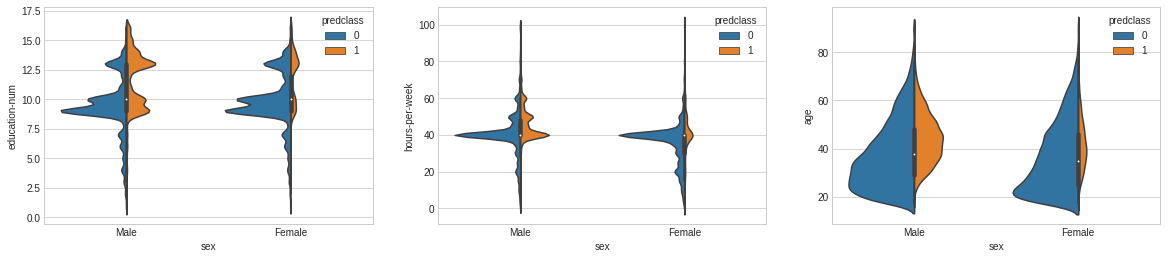

In [46]:
# Historical Trends on the Sex, Education, HPW and Age impact on Income.
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,4)) 
plt.subplot(1, 3, 1)
sns.violinplot(x='sex', y='education-num', hue='predclass', data=dataset_con, split=True, scale='count');

plt.subplot(1, 3, 2)
sns.violinplot(x='sex', y='hours-per-week', hue='predclass', data=dataset_con, split=True, scale='count');

plt.subplot(1, 3, 3)
sns.violinplot(x='sex', y='age', hue='predclass', data=dataset_con, split=True, scale='count');

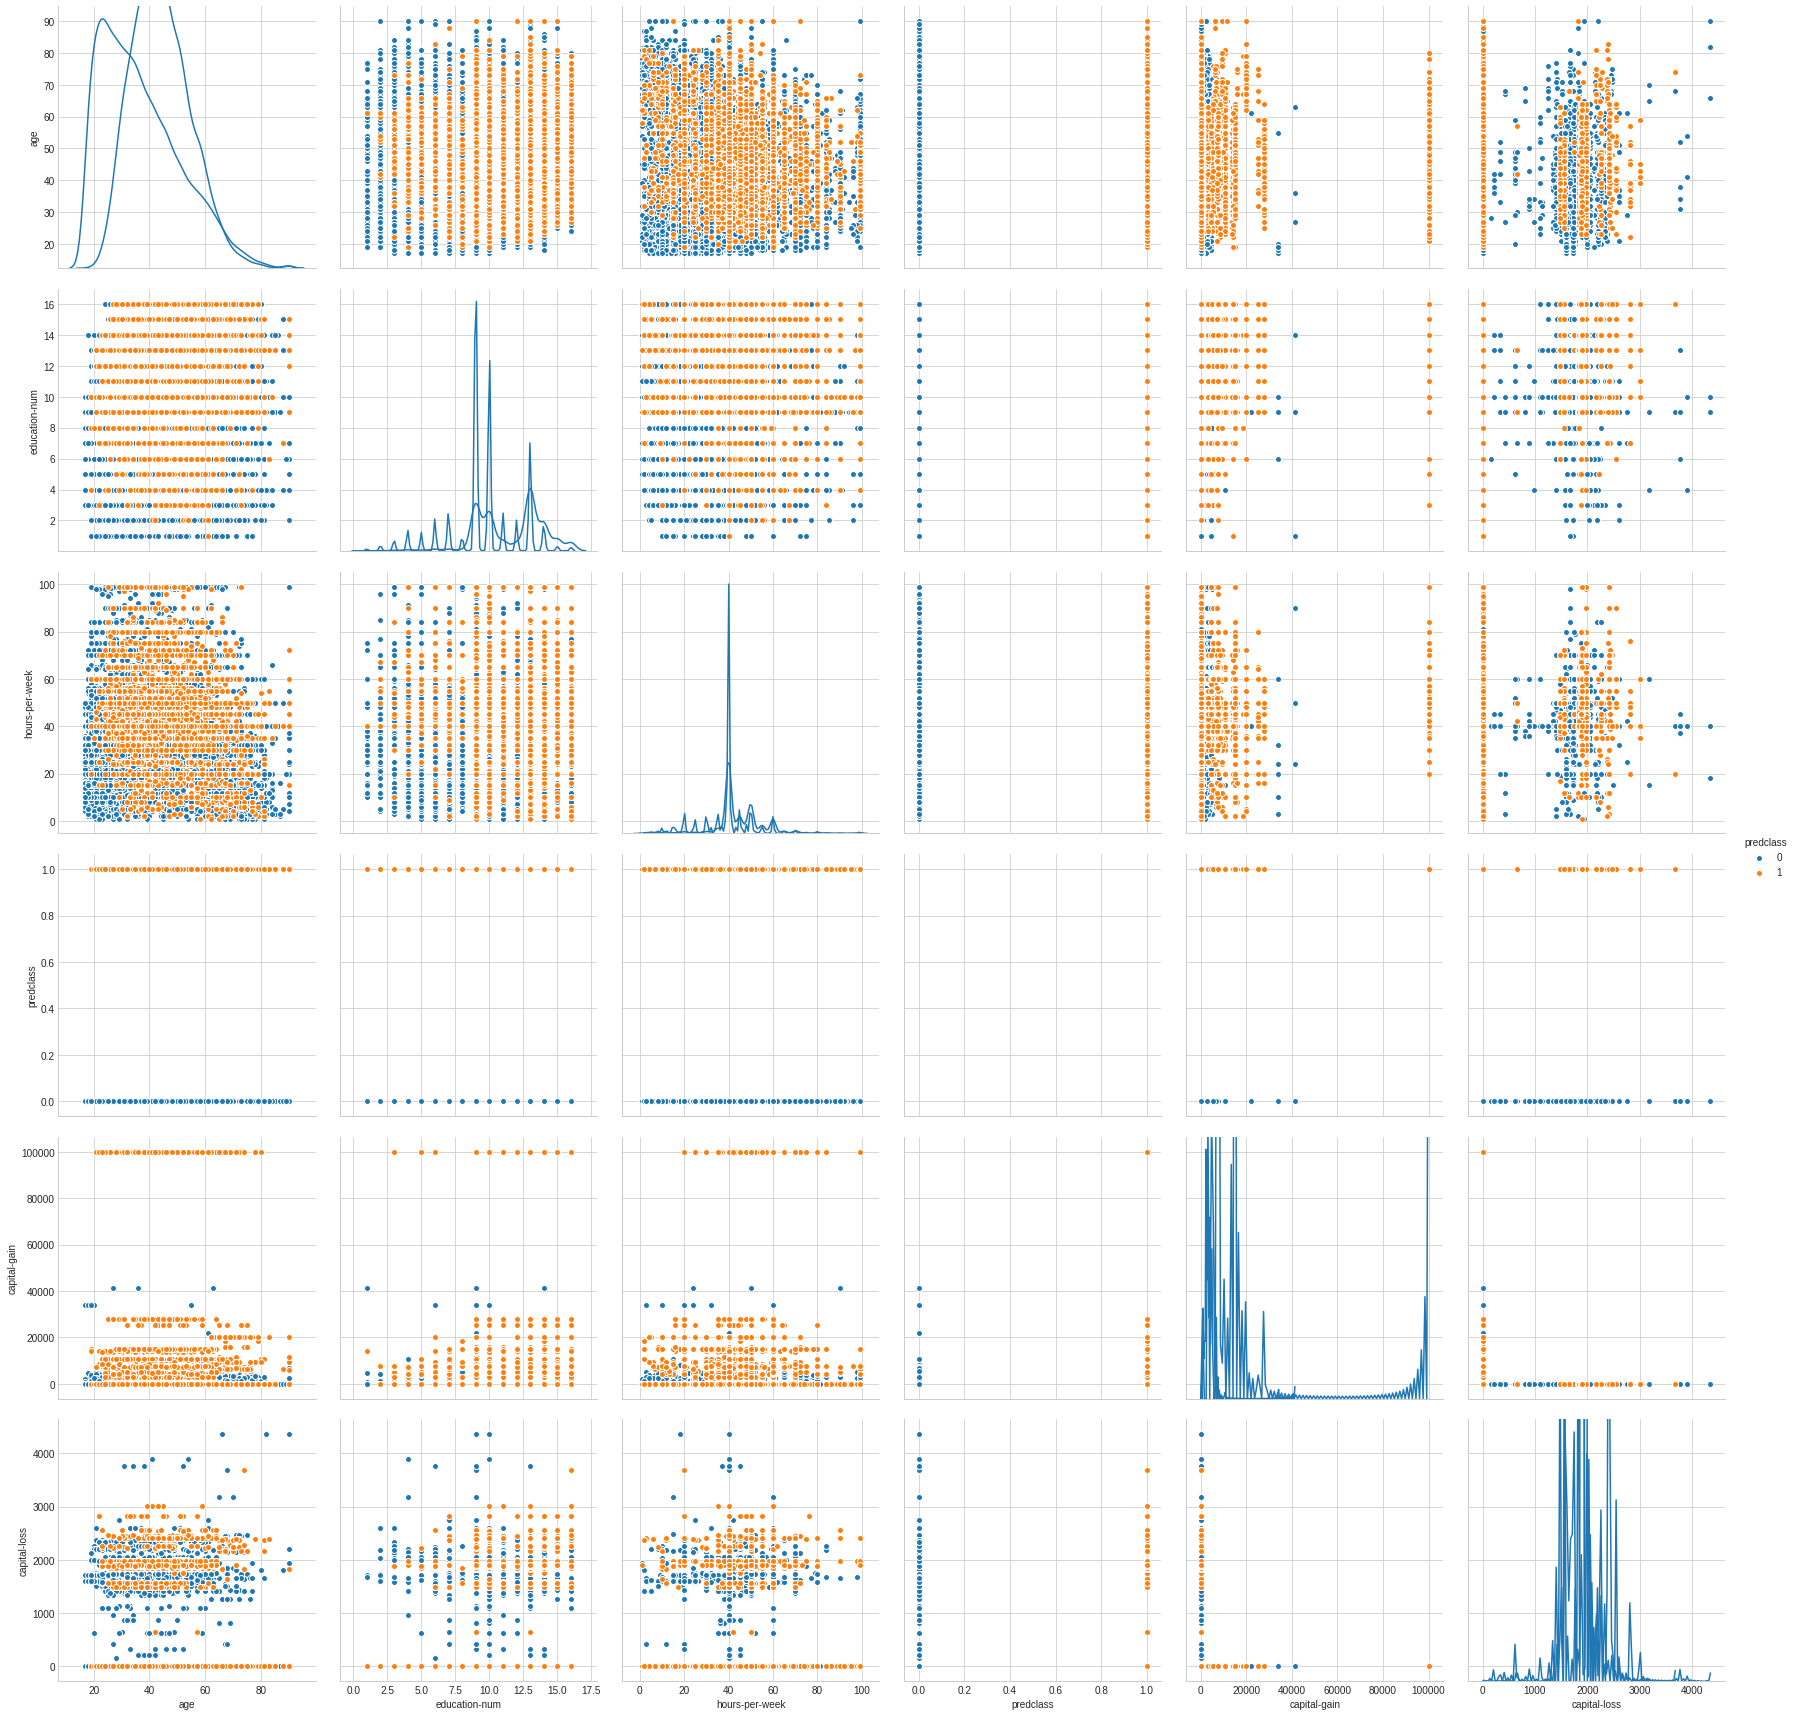

In [47]:
# Interaction between pairs of features.
sns.pairplot(dataset_con[['age','education-num','hours-per-week','predclass','capital-gain','capital-loss']], 
             hue="predclass", 
             diag_kind="kde",
             size=4);

## Feature Crossing: Age + Hours Per Week

So far, we have modified and cleaned features that existed in our dataset. However, we can go further and create a new new variables, adding human knowledge on the interaction between features.

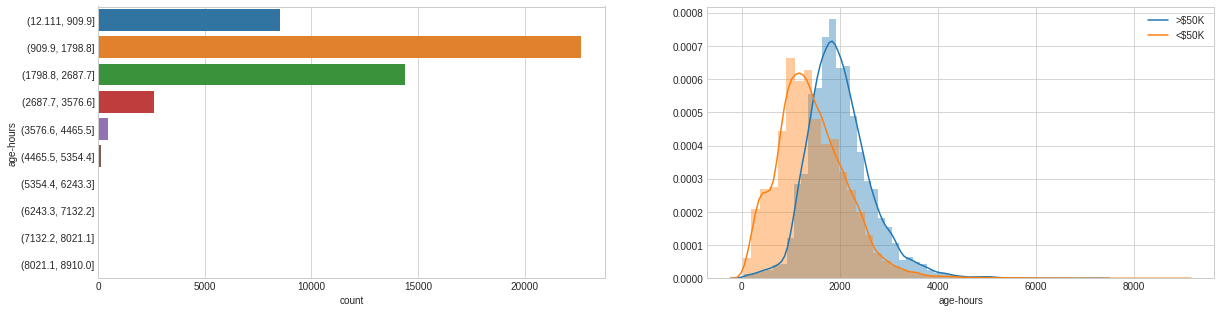

In [48]:
# Crossing Numerical Features
dataset_con['age-hours'] = dataset_con['age'] * dataset_con['hours-per-week']

dataset_bin['age-hours'] = pd.cut(dataset_con['age-hours'], 10)
dataset_con['age-hours'] = dataset_con['age-hours']

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,5)) 
plt.subplot(1, 2, 1)
sns.countplot(y="age-hours", data=dataset_bin);
plt.subplot(1, 2, 2)
sns.distplot(dataset_con.loc[dataset_con['predclass'] == 1]['age-hours'], kde_kws={"label": ">$50K"});
sns.distplot(dataset_con.loc[dataset_con['predclass'] == 0]['age-hours'], kde_kws={"label": "<$50K"});

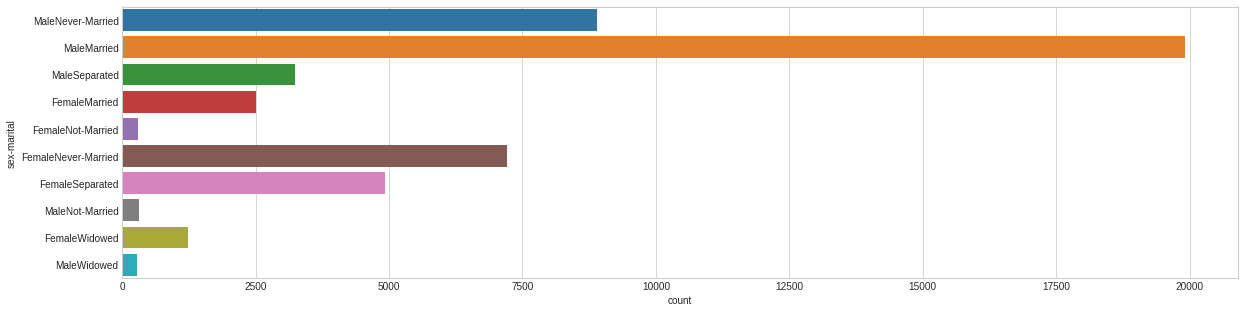

In [49]:
# Crossing Categorical Features
dataset_bin['sex-marital'] = dataset_con['sex-marital'] = dataset_con['sex'] + dataset_con['marital-status']

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,5)) 
sns.countplot(y="sex-marital", data=dataset_bin);

## Feature Encoding

Remember that Machine Learning algorithms perform Linear Algebra on Matrices, which means all features need have numeric values. The process of converting Categorical Features into values is called Encoding. Let's perform both One-Hot and Label encoding.

In [50]:
# One Hot Encodes all labels before Machine Learning
one_hot_cols = dataset_bin.columns.tolist()
one_hot_cols.remove('predclass')
dataset_bin_enc = pd.get_dummies(dataset_bin, columns=one_hot_cols)

dataset_bin_enc.head()

,predclass,"age_(16.927, 24.3]","age_(24.3, 31.6]","age_(31.6, 38.9]","age_(38.9, 46.2]","age_(46.2, 53.5]","age_(53.5, 60.8]","age_(60.8, 68.1]","age_(68.1, 75.4]","age_(75.4, 82.7]",...,sex-marital_FemaleMarried,sex-marital_FemaleNever-Married,sex-marital_FemaleNot-Married,sex-marital_FemaleSeparated,sex-marital_FemaleWidowed,sex-marital_MaleMarried,sex-marital_MaleNever-Married,sex-marital_MaleNot-Married,sex-marital_MaleSeparated,sex-marital_MaleWidowed
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [51]:
# Label Encode all labels
dataset_con_enc = dataset_con.apply(LabelEncoder().fit_transform)

dataset_con_enc.head()

,predclass,age,workclass,occupation,native-country,education,marital-status,fnlwgt,education-num,hours-per-week,capital-gain,capital-loss,sex,race,relationship,age-hours,sex-marital
0,0,22,2800,2809,864,1,1,3461,12,39,27,0,1,4,1,695,6
1,0,33,2803,2812,864,1,0,3788,12,12,0,0,1,4,0,334,5
2,0,21,2802,2810,864,5,3,18342,8,39,0,0,1,4,1,683,8
3,0,36,2802,2810,864,3,0,19995,6,39,0,0,1,2,0,890,5
4,0,11,2802,2813,863,1,0,25405,12,39,0,0,0,2,5,530,0


## Feature Reduction / Selection

Once we have our features ready to use, we might find that the number of features available is too large to be run in a reasonable timeframe by our machine learning algorithms. There's a number of options available to us for feature reduction and feature selection.

- **Dimensionality Reduction:**
    - **Principal Component Analysis (PCA):** Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. This transformation is defined in such a way that the first principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components.
    - **Singular Value Decomposition (SVD):** SVD is a factorization of a real or complex matrix. It is the generalization of the eigendecomposition of a positive semidefinite normal matrix (for example, a symmetric matrix with positive eigenvalues) to any m×n  matrix via an extension of the polar decomposition. It has many useful applications in signal processing and statistics.


- **Feature Importance/Relevance:**
    - **Filter Methods:** Filter type methods select features based only on general metrics like the correlation with the variable to predict. Filter methods suppress the least interesting variables. The other variables will be part of a classification or a regression model used to classify or to predict data. These methods are particularly effective in computation time and robust to overfitting.
    - **Wrapper Methods:** Wrapper methods evaluate subsets of variables which allows, unlike filter approaches, to detect the possible interactions between variables. The two main disadvantages of these methods are : The increasing overfitting risk when the number of observations is insufficient. AND. The significant computation time when the number of variables is large.
    - **Embedded Methods:** Embedded methods try to combine the advantages of both previous methods. A learning algorithm takes advantage of its own variable selection process and performs feature selection and classification simultaneously.

### Feature Correlation

Correlation ia s measure of how much two random variables change together. Features should be uncorrelated with each other and highly correlated to the feature we’re trying to predict.

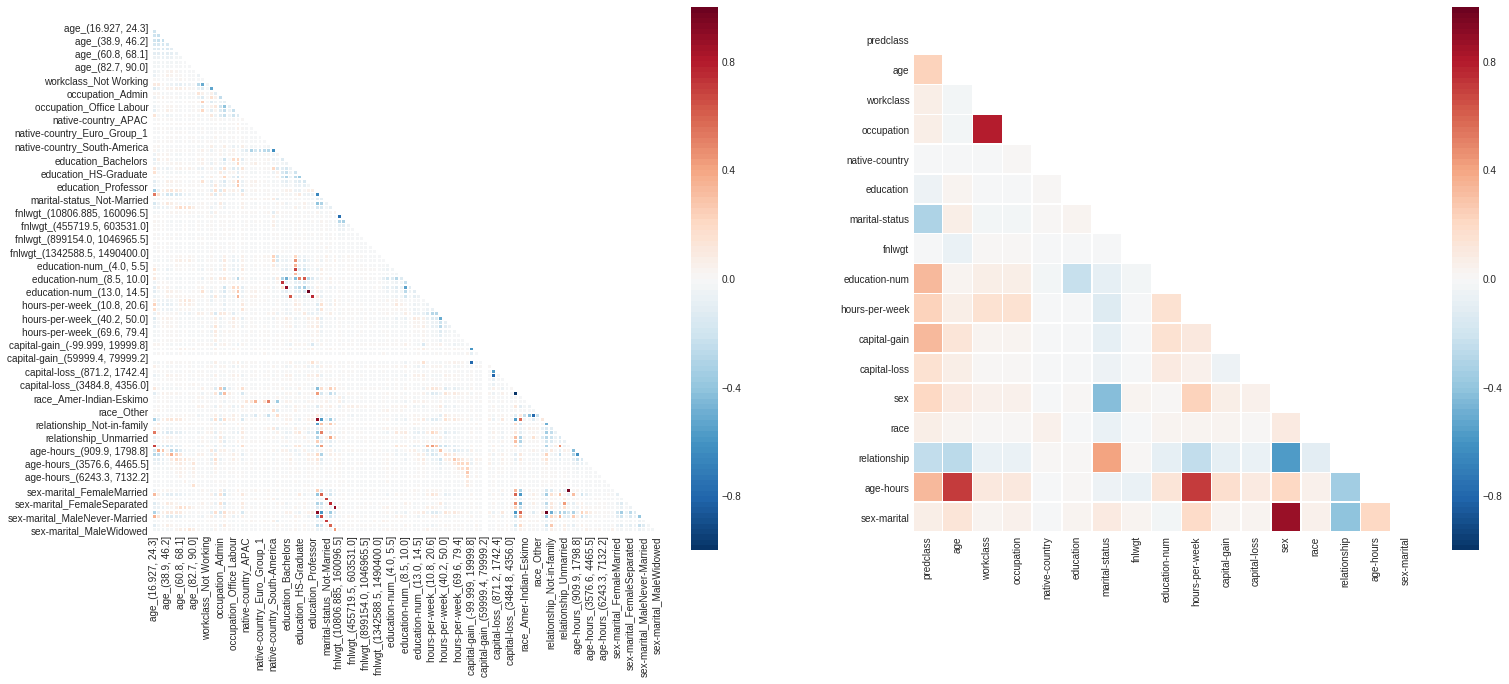

In [52]:
# Create a correlation plot of both datasets.
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(25,10)) 

plt.subplot(1, 2, 1)
# Generate a mask for the upper triangle
mask = np.zeros_like(dataset_bin_enc.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dataset_bin_enc.corr(), 
            vmin=-1, vmax=1, 
            square=True, 
            cmap=sns.color_palette("RdBu_r", 100), 
            mask=mask, 
            linewidths=.5);

plt.subplot(1, 2, 2)
mask = np.zeros_like(dataset_con_enc.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dataset_con_enc.corr(), 
            vmin=-1, vmax=1, 
            square=True, 
            cmap=sns.color_palette("RdBu_r", 100), 
            mask=mask, 
            linewidths=.5);

### Feature Importance

Random forest consists of a number of decision trees. Every node in the decision trees is a condition on a single feature, designed to split the dataset into two so that similar response values end up in the same set. The measure based on which the (locally) optimal condition is chosen is called impurity. When training a tree, it can be computed how much each feature decreases the weighted impurity in a tree. For a forest, the impurity decrease from each feature can be averaged and the features are ranked according to this measure. This is the feature importance measure exposed in sklearn’s Random Forest implementations.

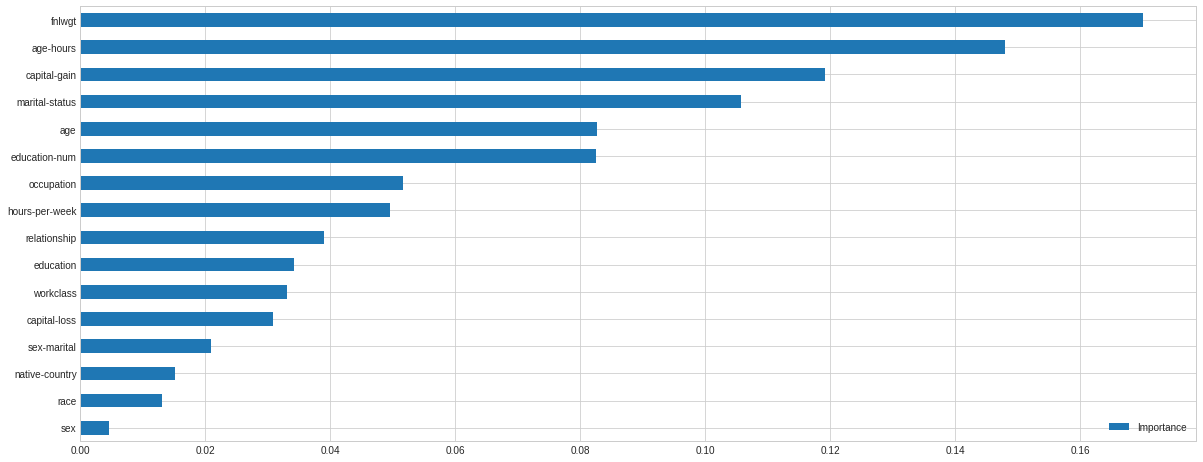

In [53]:
# Using Random Forest to gain an insight on Feature Importance
clf = RandomForestClassifier()
clf.fit(dataset_con_enc.drop('predclass', axis=1), dataset_con_enc['predclass'])

plt.style.use('seaborn-whitegrid')
importance = clf.feature_importances_
importance = pd.DataFrame(importance, index=dataset_con_enc.drop('predclass', axis=1).columns, columns=["Importance"])
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20,len(importance)/2));

### PCA

Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. This transformation is defined in such a way that the first principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components.

We can use PCA to reduce the number of features to use in our ML algorithms, and graphing the variance gives us an idea of how many features we really need to represent our dataset fully.

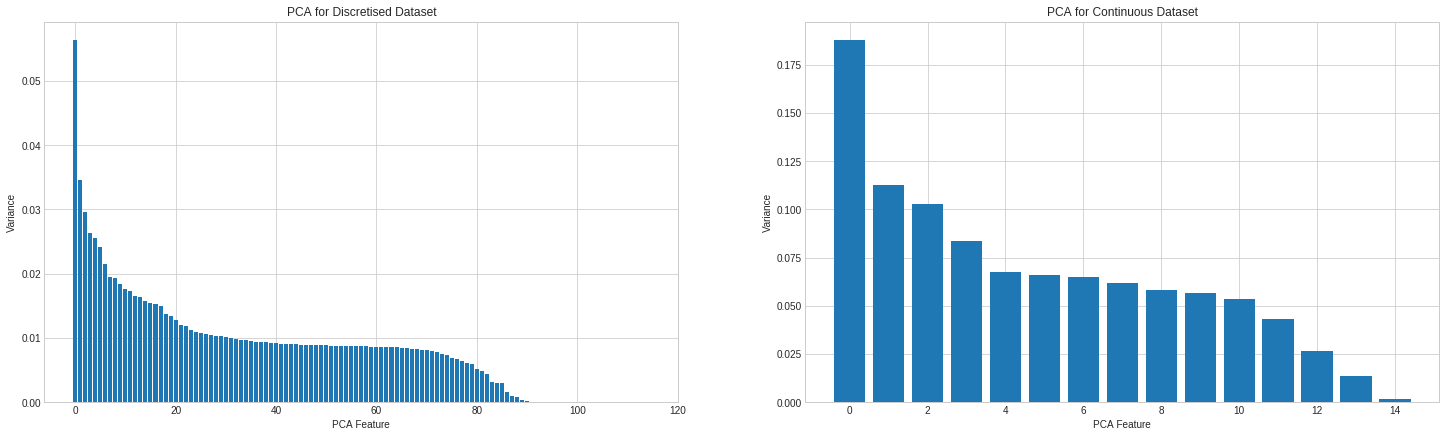

In [54]:
# Calculating PCA for both datasets, and graphing the Variance for each feature, per dataset
std_scale = preprocessing.StandardScaler().fit(dataset_bin_enc.drop('predclass', axis=1))
X = std_scale.transform(dataset_bin_enc.drop('predclass', axis=1))
pca1 = PCA(n_components=len(dataset_bin_enc.columns)-1)
fit1 = pca1.fit(X)

std_scale = preprocessing.StandardScaler().fit(dataset_con_enc.drop('predclass', axis=1))
X = std_scale.transform(dataset_con_enc.drop('predclass', axis=1))
pca2 = PCA(n_components=len(dataset_con_enc.columns)-2)
fit2 = pca2.fit(X)

# Graphing the variance per feature
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(25,7)) 

plt.subplot(1, 2, 1)
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.title('PCA for Discretised Dataset')
plt.bar(range(0, fit1.explained_variance_ratio_.size), fit1.explained_variance_ratio_);

plt.subplot(1, 2, 2)
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.title('PCA for Continuous Dataset')
plt.bar(range(0, fit2.explained_variance_ratio_.size), fit2.explained_variance_ratio_);

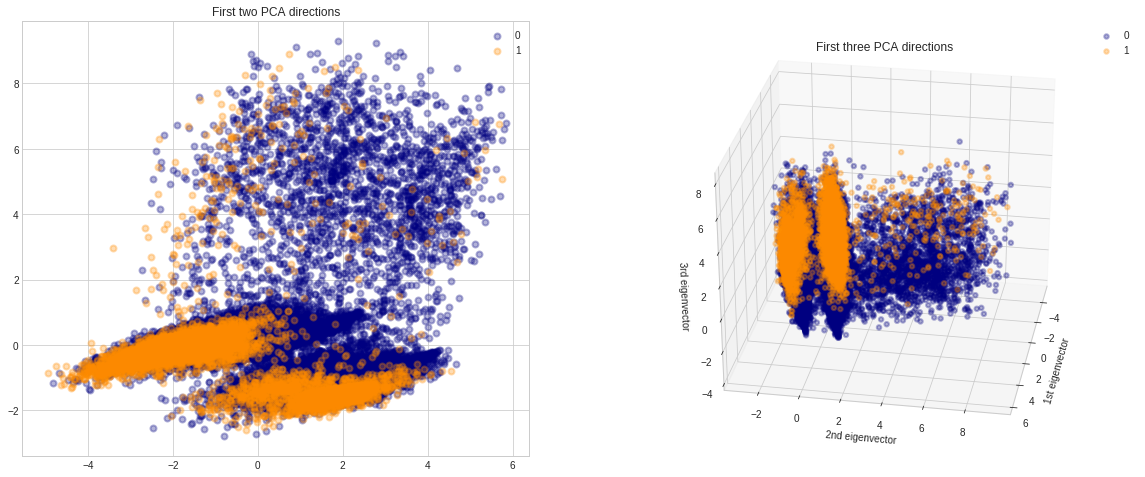

In [55]:
# PCA's components graphed in 2D and 3D
# Apply Scaling 
std_scale = preprocessing.StandardScaler().fit(dataset_con_enc.drop('predclass', axis=1))
X = std_scale.transform(dataset_con_enc.drop('predclass', axis=1))
y = dataset_con_enc['predclass']

# Formatting
target_names = [0,1]
colors = ['navy','darkorange']
lw = 2
alpha = 0.3
# 2 Components PCA
plt.style.use('seaborn-whitegrid')
plt.figure(2, figsize=(20, 8))

plt.subplot(1, 2, 1)
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], 
                color=color, 
                alpha=alpha, 
                lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('First two PCA directions');

# 3 Components PCA
ax = plt.subplot(1, 2, 2, projection='3d')

pca = PCA(n_components=3)
X_reduced = pca.fit(X).transform(X)
for color, i, target_name in zip(colors, [0, 1], target_names):
    ax.scatter(X_reduced[y == i, 0], X_reduced[y == i, 1], X_reduced[y == i, 2], 
               color=color,
               alpha=alpha,
               lw=lw, 
               label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")
ax.set_zlabel("3rd eigenvector")

# rotate the axes
ax.view_init(30, 10)

### Recursive Feature Elimination

Feature ranking with recursive feature elimination and cross-validated selection of the best number of features.

Feature Ranking For Non-Discretised: [1 3 4 2 1 1 5 1 1 1 1 1 1 1 1 1]
Optimal number of features : 12


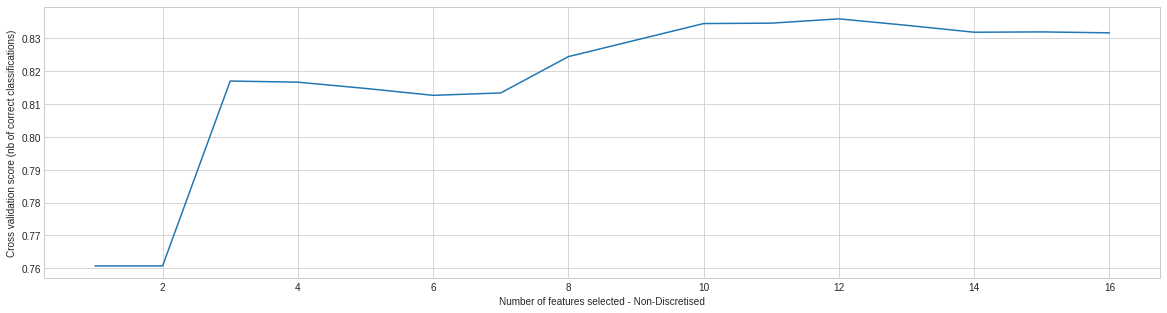

In [56]:
# Calculating RFE for non-discretised dataset, and graphing the Importance for each feature, per dataset
selector1 = RFECV(LogisticRegression(), step=1, cv=5, n_jobs=-1)
selector1 = selector1.fit(dataset_con_enc.drop('predclass', axis=1).values, dataset_con_enc['predclass'].values)
print("Feature Ranking For Non-Discretised: %s" % selector1.ranking_)
print("Optimal number of features : %d" % selector1.n_features_)
# Plot number of features VS. cross-validation scores
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,5)) 
plt.xlabel("Number of features selected - Non-Discretised")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector1.grid_scores_) + 1), selector1.grid_scores_);

# Feature space could be subsetted like so:
dataset_con_enc = dataset_con_enc[dataset_con_enc.columns[np.insert(selector1.support_, 0, True)]]

## Selecting Dataset

We now have two datasets to choose from to apply our ML algorithms. The one-hot-encoded, and the label-encoded. For now, we have decided not to use feature reduction or selection algorithms.

In [57]:
# OPTIONS: 
# - dataset_bin_enc
# - dataset_con_enc

# Change the dataset to test how would the algorithms perform under a differently encoded dataset.

selected_dataset = dataset_con_enc

In [58]:
selected_dataset.head(2)

,predclass,age,education,marital-status,education-num,hours-per-week,capital-gain,capital-loss,sex,race,relationship,age-hours,sex-marital
0,0,22,1,1,12,39,27,0,1,4,1,695,6
1,0,33,1,0,12,12,0,0,1,4,0,334,5


## Splitting Data into Training and Testing Datasets

We need to split the data back into the training and testing datasets. Remember we joined both right at the beginning.

In [59]:
# Splitting the Training and Test data sets
train = selected_dataset.loc[0:32560,:]
test = selected_dataset.loc[32560:,:]

### Removing Samples with Missing data

We could have removed rows with missing data during feature cleaning, but we're choosing to do it at this point. It's easier to do it this way, right after we split the data into Training and Testing. Otherwise we would have had to keep track of the number of deleted rows in our data and take that into account when deciding on a splitting boundary for our joined data.

In [60]:
# Given missing fields are a small percentange of the overall dataset, 
# we have chosen to delete them.
train = train.dropna(axis=0)
test = test.dropna(axis=0)

### Rename datasets before Machine Learning algos

In [61]:
X_train_w_label = train
X_train = train.drop(['predclass'], axis=1)
y_train = train['predclass'].astype('int64')
X_test  = test.drop(['predclass'], axis=1)
y_test  = test['predclass'].astype('int64')

## Machine Learning Algorithms

### Data Review

Let's take one last peek at our data before we start running the Machine Learning algorithms.

In [62]:
X_train.shape

(32561, 12)

In [63]:
X_train.head()

,age,education,marital-status,education-num,hours-per-week,capital-gain,capital-loss,sex,race,relationship,age-hours,sex-marital
0,22,1,1,12,39,27,0,1,4,1,695,6
1,33,1,0,12,12,0,0,1,4,0,334,5
2,21,5,3,8,39,0,0,1,4,1,683,8
3,36,3,0,6,39,0,0,1,2,0,890,5
4,11,1,0,12,39,0,0,0,2,5,530,0


In [64]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: predclass, dtype: int64

In [65]:
# Setting a random seed will guarantee we get the same results 
# every time we run our training and testing.
random.seed(1)

### Algorithms

From here, we will be running the following algorithms.

- KNN
- Logistic Regression
- Random Forest
- Naive Bayes
- Stochastic Gradient Decent
- Linear SVC
- Decision Tree
- Gradient Boosted Trees

Because there's a great deal of repetitiveness on the code for each, we'll create a custom function to analyse this.

For some algorithms, we have also chosen to run a Random Hyperparameter search, to select the best hyperparameters for a given algorithm.

In [66]:
# calculate the fpr and tpr for all thresholds of the classification
def plot_roc_curve(y_test, preds):
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [67]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, X_test, cv):
    # One Pass
    model = algo.fit(X_train, y_train)
    test_pred = model.predict(X_test)
    if (isinstance(algo, (LogisticRegression, 
                          KNeighborsClassifier, 
                          GaussianNB, 
                          DecisionTreeClassifier, 
                          RandomForestClassifier,
                          GradientBoostingClassifier))):
        probs = model.predict_proba(X_test)[:,1]
    else:
        probs = "Not Available"
    acc = round(model.score(X_test, y_test) * 100, 2) 
    # CV 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    return train_pred, test_pred, acc, acc_cv, probs

In [68]:
# Logistic Regression - Random Search for Hyperparameters

# Utility function to report best scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
# Specify parameters and distributions to sample from
param_dist = {'penalty': ['l2', 'l1'], 
                         'class_weight': [None, 'balanced'],
                         'C': np.logspace(-20, 20, 10000), 
                         'intercept_scaling': np.logspace(-20, 20, 10000)}

# Run Randomized Search
n_iter_search = 10
lrc = LogisticRegression()
random_search = RandomizedSearchCV(lrc, 
                                   n_jobs=-1, 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 133.64 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.826 (std: 0.004)
Parameters: {'penalty': 'l1', 'C': 89288407.976351842, 'intercept_scaling': 3694509228133852.5, 'class_weight': None}

Model with rank: 2
Mean validation score: 0.821 (std: 0.004)
Parameters: {'penalty': 'l1', 'C': 0.0016971607224669271, 'intercept_scaling': 9366927519655434.0, 'class_weight': None}

Model with rank: 3
Mean validation score: 0.773 (std: 0.004)
Parameters: {'penalty': 'l2', 'C': 310062428986889.81, 'intercept_scaling': 5.5985402837678808e-20, 'class_weight': 'balanced'}

Model with rank: 4
Mean validation score: 0.772 (std: 0.004)
Parameters: {'penalty': 'l1', 'C': 0.0029767843565561189, 'intercept_scaling': 7.3364599094691022e-06, 'class_weight': 'balanced'}

Model with rank: 5
Mean validation score: 0.759 (std: 0.000)
Parameters: {'penalty': 'l1', 'C': 8.2564181364827476e-13, 'intercept_scaling': 8.9803927281375161e-08, 'class_weigh

In [69]:
# Logistic Regression
start_time = time.time()
train_pred_log, test_pred_log, acc_log, acc_cv_log, probs_log = fit_ml_algo(LogisticRegression(n_jobs = -1), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, 
                                                                 10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 83.66
Accuracy CV 10-Fold: 83.51
Running Time: 0:00:02.440803


In [70]:
print metrics.classification_report(y_train, train_pred_log) 

             precision    recall  f1-score   support

          0       0.86      0.94      0.90     24720
          1       0.72      0.52      0.60      7841

avg / total       0.83      0.84      0.83     32561



In [71]:
print metrics.classification_report(y_test, test_pred_log) 

             precision    recall  f1-score   support

          0       0.86      0.94      0.90     12435
          1       0.71      0.51      0.60      3847

avg / total       0.83      0.84      0.83     16282



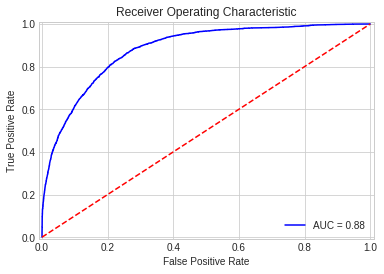

In [72]:
plot_roc_curve(y_test, probs_log)

In [73]:
# k-Nearest Neighbors
start_time = time.time()
train_pred_knn, test_pred_knn, acc_knn, acc_cv_knn, probs_knn = fit_ml_algo(KNeighborsClassifier(n_neighbors = 3,
                                                                                                 n_jobs = -1), 
                                                                                                 X_train, 
                                                                                                 y_train, 
                                                                                                 X_test, 
                                                                                                 10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 81.04
Accuracy CV 10-Fold: 81.51
Running Time: 0:00:02.154185


In [74]:
print metrics.classification_report(y_train, train_pred_knn) 

             precision    recall  f1-score   support

          0       0.87      0.89      0.88     24720
          1       0.63      0.57      0.60      7841

avg / total       0.81      0.82      0.81     32561



In [75]:
print metrics.classification_report(y_test, test_pred_knn) 

             precision    recall  f1-score   support

          0       0.87      0.89      0.88     12435
          1       0.61      0.56      0.58      3847

avg / total       0.81      0.81      0.81     16282



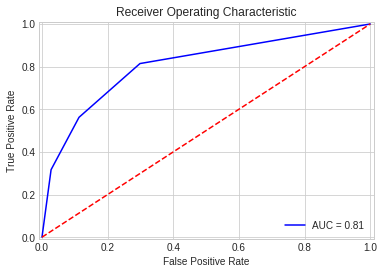

In [76]:
plot_roc_curve(y_test, probs_knn)

In [77]:
# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, test_pred_gaussian, acc_gaussian, acc_cv_gaussian, probs_gau = fit_ml_algo(GaussianNB(), 
                                                                                     X_train, 
                                                                                     y_train, 
                                                                                     X_test, 
                                                                                     10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 81.84
Accuracy CV 10-Fold: 81.99
Running Time: 0:00:00.435668


In [78]:
print metrics.classification_report(y_train, train_pred_gaussian) 

             precision    recall  f1-score   support

          0       0.87      0.90      0.88     24720
          1       0.64      0.57      0.60      7841

avg / total       0.81      0.82      0.82     32561



In [79]:
print metrics.classification_report(y_test, test_pred_gaussian) 

             precision    recall  f1-score   support

          0       0.87      0.90      0.88     12435
          1       0.63      0.56      0.60      3847

avg / total       0.81      0.82      0.81     16282



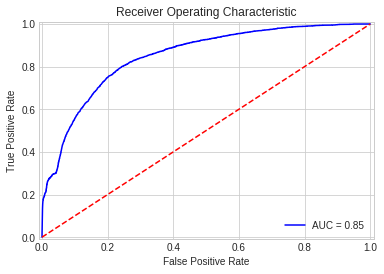

In [80]:
plot_roc_curve(y_test, probs_gau)

In [81]:
# Linear SVC
start_time = time.time()
train_pred_svc, test_pred_svc, acc_linear_svc, acc_cv_linear_svc, _ = fit_ml_algo(LinearSVC(),
                                                                                           X_train, 
                                                                                           y_train,
                                                                                           X_test, 
                                                                                           10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 78.54
Accuracy CV 10-Fold: 75.47
Running Time: 0:00:15.524528


In [82]:
print metrics.classification_report(y_train, train_pred_svc) 

             precision    recall  f1-score   support

          0       0.81      0.88      0.85     24720
          1       0.49      0.35      0.41      7841

avg / total       0.73      0.75      0.74     32561



In [83]:
print metrics.classification_report(y_test, test_pred_svc) 

             precision    recall  f1-score   support

          0       0.78      1.00      0.88     12435
          1       0.99      0.09      0.17      3847

avg / total       0.83      0.79      0.71     16282



In [84]:
# Stochastic Gradient Descent
start_time = time.time()
train_pred_sgd, test_pred_sgd, acc_sgd, acc_cv_sgd, _ = fit_ml_algo(SGDClassifier(n_jobs = -1), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, 
                                                                 10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 66.5
Accuracy CV 10-Fold: 64.61
Running Time: 0:00:00.672012


In [85]:
print metrics.classification_report(y_train, train_pred_sgd) 

             precision    recall  f1-score   support

          0       0.82      0.68      0.74     24720
          1       0.35      0.54      0.43      7841

avg / total       0.71      0.65      0.67     32561



In [86]:
print metrics.classification_report(y_test, test_pred_sgd) 

             precision    recall  f1-score   support

          0       0.95      0.60      0.73     12435
          1       0.40      0.89      0.56      3847

avg / total       0.82      0.67      0.69     16282



In [87]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, test_pred_dt, acc_dt, acc_cv_dt, probs_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                             X_train, 
                                                             y_train, 
                                                             X_test, 
                                                             10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 82.59
Accuracy CV 10-Fold: 82.78
Running Time: 0:00:00.693793


In [88]:
print metrics.classification_report(y_train, train_pred_dt) 

             precision    recall  f1-score   support

          0       0.87      0.90      0.89     24720
          1       0.66      0.59      0.62      7841

avg / total       0.82      0.83      0.82     32561



In [89]:
print metrics.classification_report(y_test, test_pred_dt) 

             precision    recall  f1-score   support

          0       0.87      0.90      0.89     12435
          1       0.65      0.58      0.61      3847

avg / total       0.82      0.83      0.82     16282



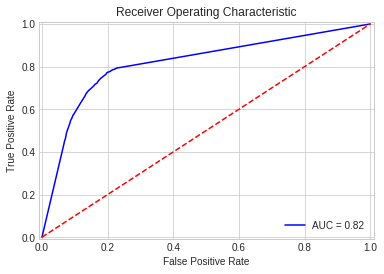

In [90]:
plot_roc_curve(y_test, probs_dt)

In [91]:
# Random Forest Classifier - Random Search for Hyperparameters

# Utility function to report best scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
# Specify parameters and distributions to sample from
param_dist = {"max_depth": [10, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 20),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# Run Randomized Search
n_iter_search = 10
rfc = RandomForestClassifier(n_estimators=10)
random_search = RandomizedSearchCV(rfc, 
                                   n_jobs = -1, 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 3.29 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.857 (std: 0.003)
Parameters: {'bootstrap': True, 'min_samples_leaf': 1, 'min_samples_split': 6, 'criterion': 'gini', 'max_features': 9, 'max_depth': 10}

Model with rank: 2
Mean validation score: 0.856 (std: 0.003)
Parameters: {'bootstrap': True, 'min_samples_leaf': 5, 'min_samples_split': 10, 'criterion': 'entropy', 'max_features': 9, 'max_depth': 10}

Model with rank: 3
Mean validation score: 0.856 (std: 0.003)
Parameters: {'bootstrap': False, 'min_samples_leaf': 3, 'min_samples_split': 16, 'criterion': 'entropy', 'max_features': 6, 'max_depth': 10}

Model with rank: 4
Mean validation score: 0.856 (std: 0.005)
Parameters: {'bootstrap': True, 'min_samples_leaf': 6, 'min_samples_split': 13, 'criterion': 'entropy', 'max_features': 10, 'max_depth': 10}

Model with rank: 5
Mean validation score: 0.855 (std: 0.003)
Parameters: {'bootstrap': True, 'min_samples_leaf': 7, 'mi

In [92]:
# Random Forest Classifier
start_time = time.time()
rfc = RandomForestClassifier(n_estimators=10, 
                             min_samples_leaf=2,
                             min_samples_split=17, 
                             criterion='gini', 
                             max_features=8)
train_pred_rf, test_pred_rf, acc_rf, acc_cv_rf, probs_rf = fit_ml_algo(rfc, 
                                                             X_train, 
                                                             y_train, 
                                                             X_test, 
                                                             10)
rf_time = (time.time() - start_time)
print("Accuracy: %s" % acc_rf)
print("Accuracy CV 10-Fold: %s" % acc_cv_rf)
print("Running Time: %s" % datetime.timedelta(seconds=rf_time))

Accuracy: 85.24
Accuracy CV 10-Fold: 85.18
Running Time: 0:00:01.722434


In [93]:
print metrics.classification_report(y_train, train_pred_rf) 

             precision    recall  f1-score   support

          0       0.88      0.93      0.91     24720
          1       0.73      0.60      0.66      7841

avg / total       0.85      0.85      0.85     32561



In [94]:
print metrics.classification_report(y_test, test_pred_rf) 

             precision    recall  f1-score   support

          0       0.88      0.93      0.91     12435
          1       0.73      0.60      0.66      3847

avg / total       0.85      0.85      0.85     16282



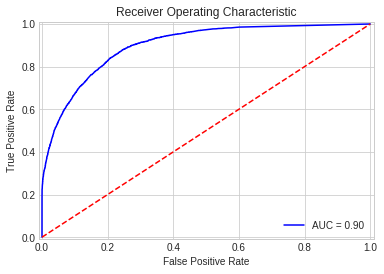

In [95]:
plot_roc_curve(y_test, probs_rf)

In [96]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, test_pred_gbt, acc_gbt, acc_cv_gbt, probs_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, 
                                                                 10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 86.32
Accuracy CV 10-Fold: 86.21
Running Time: 0:00:05.872032


In [97]:
print metrics.classification_report(y_train, train_pred_gbt) 

             precision    recall  f1-score   support

          0       0.88      0.95      0.91     24720
          1       0.78      0.59      0.67      7841

avg / total       0.86      0.86      0.86     32561



In [98]:
print metrics.classification_report(y_test, test_pred_gbt) 

             precision    recall  f1-score   support

          0       0.88      0.95      0.91     12435
          1       0.78      0.59      0.67      3847

avg / total       0.86      0.86      0.86     16282



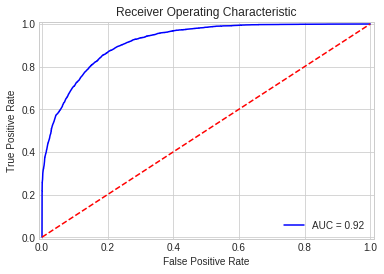

In [99]:
plot_roc_curve(y_test, probs_gbt)

## Ranking Results

Let's rank the results for all the algorithms we have used

In [100]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees'],
    'Score': [
        acc_knn, 
        acc_log, 
        acc_rf, 
        acc_gaussian, 
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc_gbt
    ]})
models.sort_values(by='Score', ascending=False)

,Model,Score
7,Gradient Boosting Trees,86.32
2,Random Forest,85.24
1,Logistic Regression,83.66
6,Decision Tree,82.59
3,Naive Bayes,81.84
0,KNN,81.04
5,Linear SVC,78.54
4,Stochastic Gradient Decent,66.50


In [101]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,     
        acc_cv_rf, 
        acc_cv_gaussian, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt
    ]})
models.sort_values(by='Score', ascending=False)

,Model,Score
7,Gradient Boosting Trees,86.21
2,Random Forest,85.18
1,Logistic Regression,83.51
6,Decision Tree,82.78
3,Naive Bayes,81.99
0,KNN,81.51
5,Linear SVC,75.47
4,Stochastic Gradient Decent,64.61


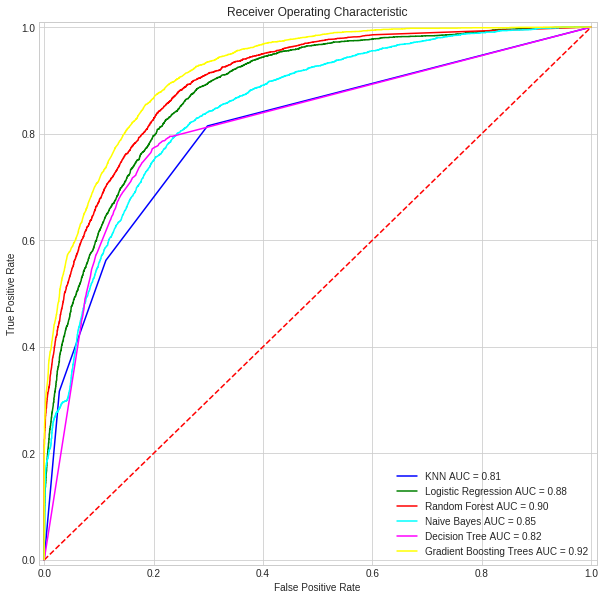

In [102]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,10)) 

models = [
    'KNN', 
    'Logistic Regression', 
    'Random Forest', 
    'Naive Bayes', 
    'Decision Tree', 
    'Gradient Boosting Trees'
]
probs = [
    probs_knn,
    probs_log,
    probs_rf,
    probs_gau,
    probs_dt,
    probs_gbt
]
colors = [
    'blue',
    'green',
    'red',
    'cyan',
    'magenta',
    'yellow',
]
    
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

def plot_roc_curves(y_test, prob, model):
    fpr, tpr, threshold = metrics.roc_curve(y_test, prob)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = model + ' AUC = %0.2f' % roc_auc, color=colors[i])
    plt.legend(loc = 'lower right')
    
for i, model in list(enumerate(models)):
    plot_roc_curves(y_test, probs[i], models[i])
    
plt.show()